# Type cleanup and Missing-value treatment study

This notebook focuses on: (1) inspecting and cleaning column types, and (2) a systematic study of missing-value patterns and imputation strategies.

It is intentionally self-contained: open and run cells in order. Adjust file paths if needed.

## Setup: imports and dataset path

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
DATA_PATH = Path('..') / 'data' / 'welddb.data'
columns = [
    "C", "Si", "Mn", "S", "P", "Ni", "Cr", "Mo", "V", "Cu", "Co", "W",
    "O", "Ti", "N", "Al", "B", "Nb", "Sn", "As", "Sb",
    "Current", "Voltage", "AC_DC", "ElectrodePolarity", "HeatInput",
    "InterpassTemp", "WeldType", "PWHT_Temp", "PWHT_Time",
    "YieldStrength", "UTS", "Elongation", "ReductionArea",
    "CharpyTemp", "CharpyImpact", "Hardness", "FATT50", "PrimaryFerrite",
    "Ferrite2ndPhase", "AcicularFerrite", "Martensite", "FerriteCarbide",
    "WeldID"
]
df = pd.read_csv(DATA_PATH, delim_whitespace=True, names=columns, na_values='N')  # load dataset

# Quick peek
df.head()

C:\Users\clemm\AppData\Local\Temp\ipykernel_25304\1410700516.py:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(DATA_PATH, delim_whitespace=True, names=columns, na_values='N')  # load dataset


,C,Si,Mn,S,P,Ni,Cr,Mo,V,Cu,...,CharpyTemp,CharpyImpact,Hardness,FATT50,PrimaryFerrite,Ferrite2ndPhase,AcicularFerrite,Martensite,FerriteCarbide,WeldID
0,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aaw
1,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-28.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aawch
2,0.037,0.30,0.65,0.008,0.012,0.0,NaN,NaN,NaN,NaN,...,-38.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Aht
3,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evans-Ni/CMn-1990/1991-0Baw
4,0.037,0.31,1.03,0.007,0.014,0.0,NaN,NaN,NaN,NaN,...,-48.0,100.0,NaN,NaN,32,28.0,40.0,0.0,0.0,Evans-Ni/CMn-1990/1991-0Bawch


## 1. Clean up data types

We inspect dtypes and perform safe conversions: parse dates, coerce numeric strings with `pd.to_numeric(errors='coerce')`, convert low-cardinality object columns to `category`, and normalize boolean-like columns. Always check the number of NaNs introduced by coercion.

In [19]:
# Show current dtypes and basic stats
dtype_table = pd.DataFrame({'dtype': df.dtypes.astype(str)})
dtype_table['n_missing'] = df.isna().sum()
dtype_table['pct_missing'] = 100 * df.isna().mean()
dtype_table['n_unique'] = df.nunique(dropna=True)
dtype_table.sort_values(['dtype', 'pct_missing'], inplace=True)
dtype_table

,dtype,n_missing,pct_missing,n_unique
C,float64,0,0.000000,81
Si,float64,0,0.000000,68
Mn,float64,0,0.000000,147
HeatInput,float64,0,0.000000,38
P,float64,10,0.605327,35
PWHT_Temp,float64,13,0.786925,19
PWHT_Time,float64,13,0.786925,21
Current,float64,248,15.012107,37
Voltage,float64,248,15.012107,24
O,float64,396,23.970944,268


In [20]:
# Helper to coerce candidate numeric columns that are strings
def coerce_numeric_candidates(frame, sample_size=1000, min_fraction_numeric=0.9):
    cand = []
    for col in frame.select_dtypes(include=['object']).columns:
        s = frame[col].dropna().astype(str)
        sample = s.sample(min(len(s), sample_size), random_state=0) if len(s)>0 else s
        numeric_count = sample.apply(lambda x: x.replace(',','').replace(' ','').lstrip('+').isdigit()).sum()
        if len(sample)>0 and (numeric_count / len(sample)) >= min_fraction_numeric:
            cand.append(col)
    return cand

numeric_candidates = coerce_numeric_candidates(df)
numeric_candidates[:20]  # show a few candidates

['Ti', 'N', 'InterpassTemp', 'PrimaryFerrite']

In [21]:
# Example conversion pipeline (do not overwrite until you inspect results)
df2 = df.copy()
# 1) parse obvious date-like columns by trying to convert a few columns heuristically
date_hints = [c for c in df2.columns if 'date' in c.lower() or 'time' in c.lower()]
for c in date_hints:
    try:
        converted = pd.to_datetime(df2[c], errors='coerce', dayfirst=False)
        n_coerced = converted.isna().sum() - df2[c].isna().sum()
        if n_coerced >= 0:
            df2[c] = converted
    except Exception as e:
        print(f'Could not parse {c}: {e}')

# 2) coerce numeric-candidate object columns
for c in numeric_candidates:
    before_na = df2[c].isna().sum()
    df2[c] = pd.to_numeric(df2[c].astype(str).str.replace(',','').str.strip(), errors='coerce')
    after_na = df2[c].isna().sum()
    print(f'Converted {c}: added {after_na - before_na} NaNs due to coercion')

# 3) convert low-cardinality object columns to category
for c in df2.select_dtypes(include=['object']).columns:
    if df2[c].nunique(dropna=True) < 50:
        df2[c] = df2[c].astype('category')

# show dtype changes
pd.DataFrame({'before': df.dtypes.astype(str), 'after': df2.dtypes.astype(str)})


Converted Ti: added 70 NaNs due to coercion
Converted N: added 59 NaNs due to coercion
Converted InterpassTemp: added 38 NaNs due to coercion
Converted PrimaryFerrite: added 2 NaNs due to coercion


,before,after
C,float64,float64
Si,float64,float64
Mn,float64,float64
S,object,category
P,float64,float64
Ni,float64,float64
Cr,float64,float64
Mo,object,object
V,object,object
Cu,object,object


## 2. Missing values: summary statistics and diagnostics

Compute missing counts and percentages per column and per row, flag columns above thresholds, and produce a compact flagging table with suggested actions.

In [22]:
def missing_summary(frame, col_threshold=0.5):
    s = frame.isna().sum()
    p = 100 * frame.isna().mean()
    out = pd.DataFrame({
        'total_missing': s,
        'pct_missing': p,
        'dtype': frame.dtypes.astype(str),
        'n_unique': frame.nunique(dropna=True)
    })
    out['action_suggestion'] = 'keep'
    out.loc[out['pct_missing']> (col_threshold*100), 'action_suggestion'] = 'consider_drop_or_model'
    return out.sort_values('pct_missing', ascending=False)

summary = missing_summary(df2)
summary.head(40)

,total_missing,pct_missing,dtype,n_unique,action_suggestion
FATT50,1621,98.123487,float64,20,consider_drop_or_model
W,1577,95.460048,category,7,consider_drop_or_model
FerriteCarbide,1563,94.612591,float64,8,consider_drop_or_model
Martensite,1563,94.612591,float64,2,consider_drop_or_model
Ferrite2ndPhase,1562,94.552058,float64,46,consider_drop_or_model
AcicularFerrite,1562,94.552058,float64,50,consider_drop_or_model
PrimaryFerrite,1556,94.188862,float64,37,consider_drop_or_model
Co,1523,92.191283,category,14,consider_drop_or_model
Hardness,1514,91.646489,object,96,consider_drop_or_model
As,1418,85.835351,category,19,consider_drop_or_model


In [23]:
# missingness per row (how many rows have many missing values)
row_missing = df2.isna().mean(axis=1).value_counts(bins=10).sort_index()
row_missing

(0.20299999999999999, 0.25]     12
(0.25, 0.295]                   24
(0.295, 0.341]                 137
(0.341, 0.386]                 142
(0.386, 0.432]                 215
(0.432, 0.477]                 574
(0.477, 0.523]                 304
(0.523, 0.568]                  75
(0.568, 0.614]                 153
(0.614, 0.659]                  16
Name: count, dtype: int64

## 3. Visual exploration and pattern analysis

Visualize missingness using seaborn/matplotlib; if `missingno` is installed, the `matrix` and `heatmap` are more convenient.

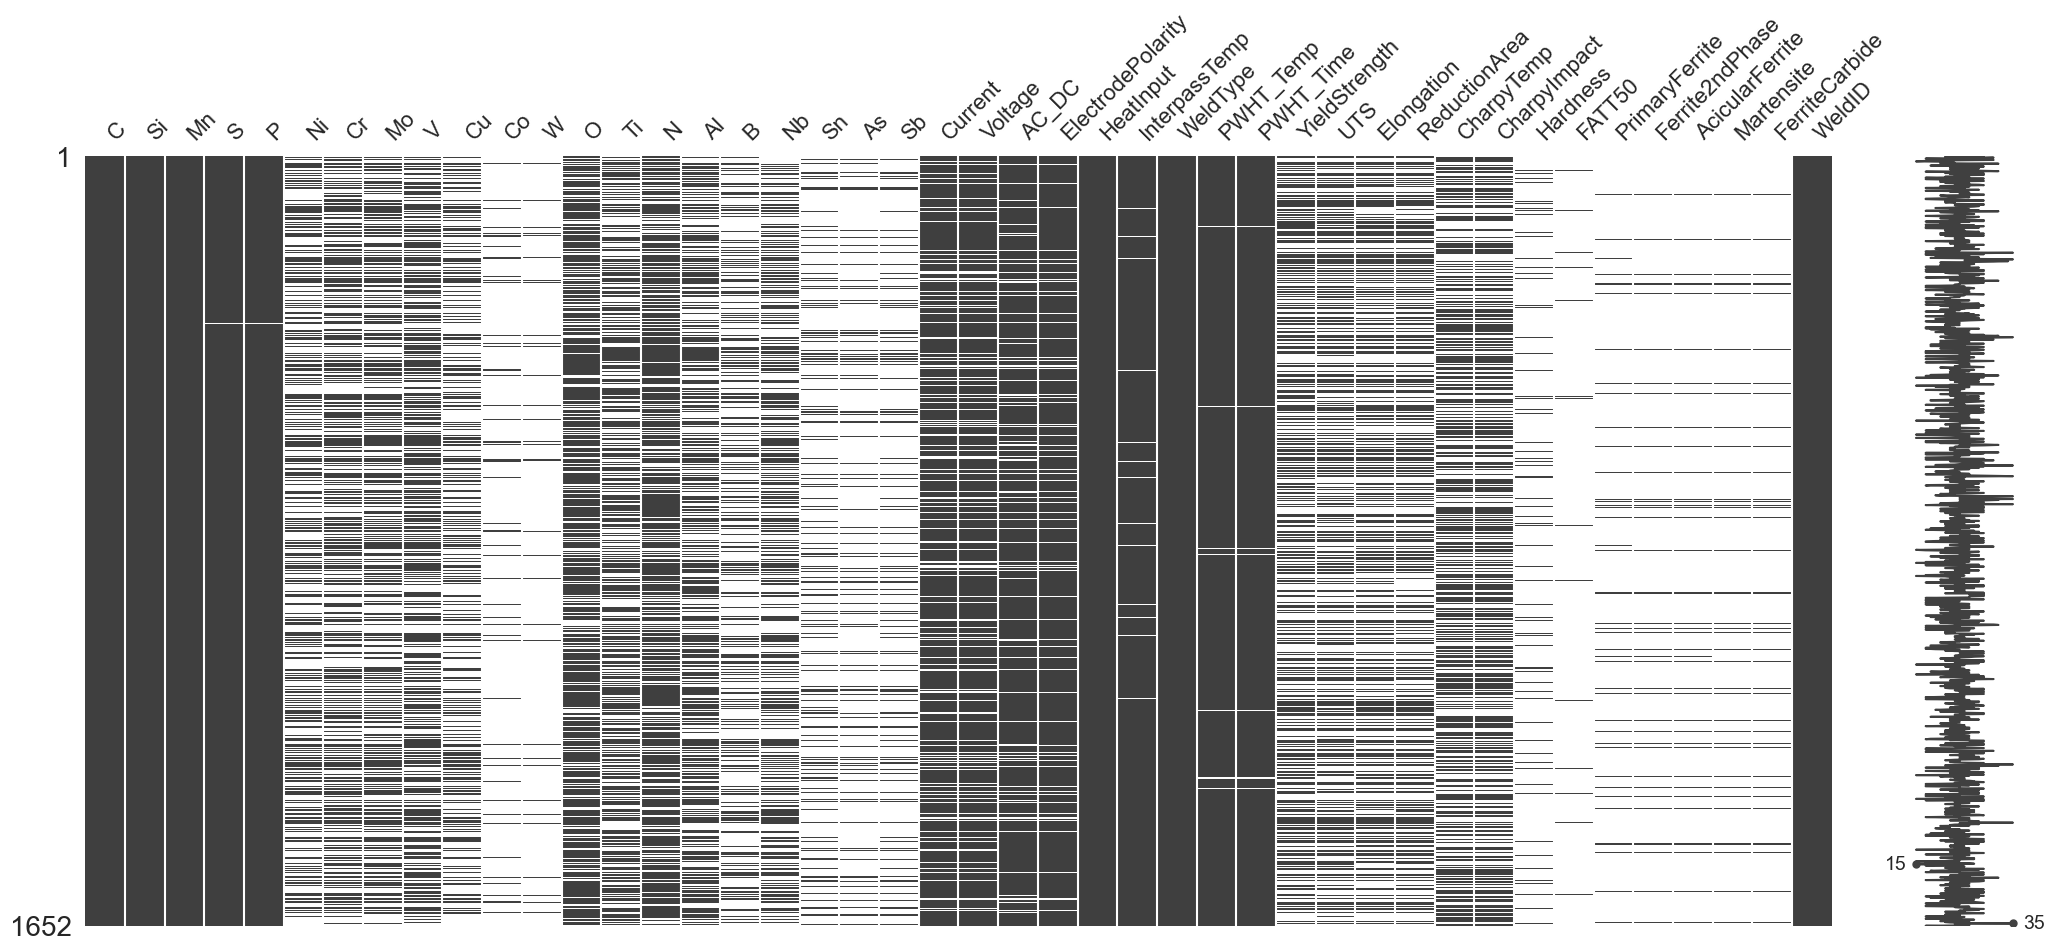

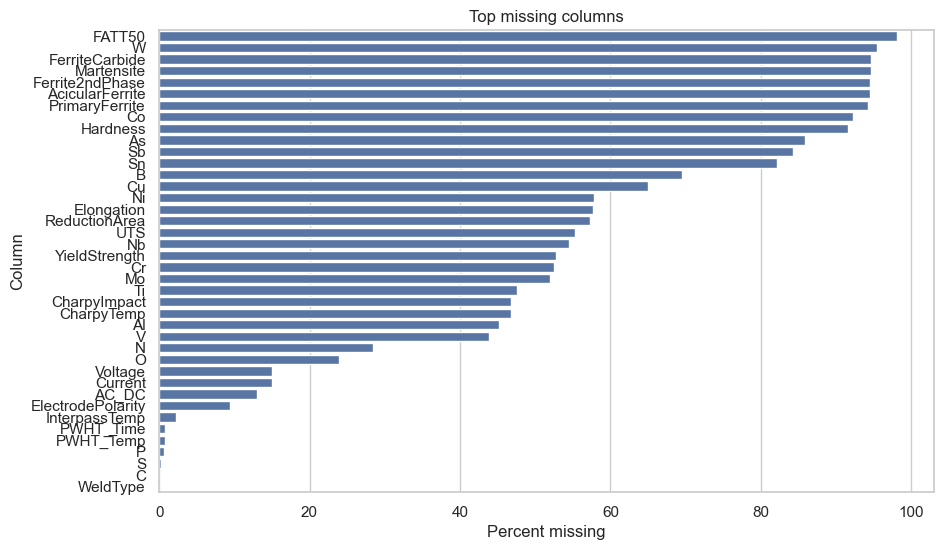

In [24]:
# Heatmap of missing values (columns x rows sub-sample for speed)
try:
    import missingno as msno
    msno.matrix(df2.sample(min(len(df2), 2000), random_state=0))
    plt.show()
except Exception:
    plt.figure(figsize=(12,6))
    sns.heatmap(df2.isna().astype(int).corr(), cmap='viridis', vmin=-1, vmax=1)
    plt.title('Correlation of missingness between columns')
    plt.show()

# barplot of missing counts for top 40 columns
top_missing = summary.head(40).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_missing, x='pct_missing', y='index')
plt.xlabel('Percent missing')
plt.ylabel('Column')
plt.title('Top missing columns')
plt.show()

## 4. Imputation strategy

The imputation strategy is : Thus we can try to intute patterns MAR, MCAR and MNAR:
- **MCAR**: correlations in the heatmap are close to 0 everywhere
- **MAR**: strong correlations between patterns of missing data
- **MNAR**: difficult to prove directly

Thus:
- **Chemical elements** (C, Mn, Cr, etc.) might be **MAR** : Correlated missing data between elements: depends on the analytical protocol
- **Mechanical properties** (YieldStrength, UTS, Elongation, etc.) might be **MAR** as well: Data missing together, therefore related to the availability of mechanical tests.
- **Microstructure** (PrimaryFerrite, AcicularFerrite, FerriteCarbide) might be **MNAR**: Probably absent when the microstructure is complex or not measured (non-random).
- **Process parameters** (Voltage, Polarity, InterpassTemp) might be **MCAR** or quasi-MCAR: Little or no correlation with other patterns of missing data.


With :

```python
process_param_columns = ['Current', 'Voltage','AC_DC', 'ElectrodePolarity', 'HeatInput', 'InterpassTemp', 'WeldType', 'PWHT_Temp', 'PWHT_Time']
chem_cols = ['C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V', 'Cu', 'Co', 'W', 'O','Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb']
mech_cols = [
    'YieldStrength', 'UTS', 'Elongation', 'ReductionArea',
    'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
]
micro_cols = [
    'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite',
    'Martensite', 'FerriteCarbide'
]

In [49]:
import sys
import os

module_path = os.path.abspath("../src")
sys.path.append(module_path)

In [59]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from preprocessing.data_cleaning import MissingValueHandler, initial_cleanup

In [61]:
# Make a first light cleanup
df = initial_cleanup(df)

# Create MissingValueHandler instance
mvh = MissingValueHandler(df)

In [62]:
# Top 20 columns with most missing values
mvh.show_missing_summary(top=20)

                         total_missing  pct_missing     dtype  n_unique
C                                    0          0.0   float32        81
CharpyTemp                           0          0.0   float32       820
ElectrodePolarity                    0          0.0  category         3
HeatInput                            0          0.0   float32        38
InterpassTemp                        0          0.0   float32        14
WeldType                             0          0.0  category        10
YieldStrength                        0          0.0   float32       830
UTS                                  0          0.0   float32       855
Elongation                           0          0.0   float32       714
ReductionArea                        0          0.0   float32       696
CharpyImpact                         0          0.0   float32       821
Voltage                              0          0.0   float32        24
Hardness                             0          0.0   float32   

,total_missing,pct_missing,dtype,n_unique
C,0,0.0,float32,81
CharpyTemp,0,0.0,float32,820
ElectrodePolarity,0,0.0,category,3
HeatInput,0,0.0,float32,38
InterpassTemp,0,0.0,float32,14
WeldType,0,0.0,category,10
YieldStrength,0,0.0,float32,830
UTS,0,0.0,float32,855
Elongation,0,0.0,float32,714
ReductionArea,0,0.0,float32,696


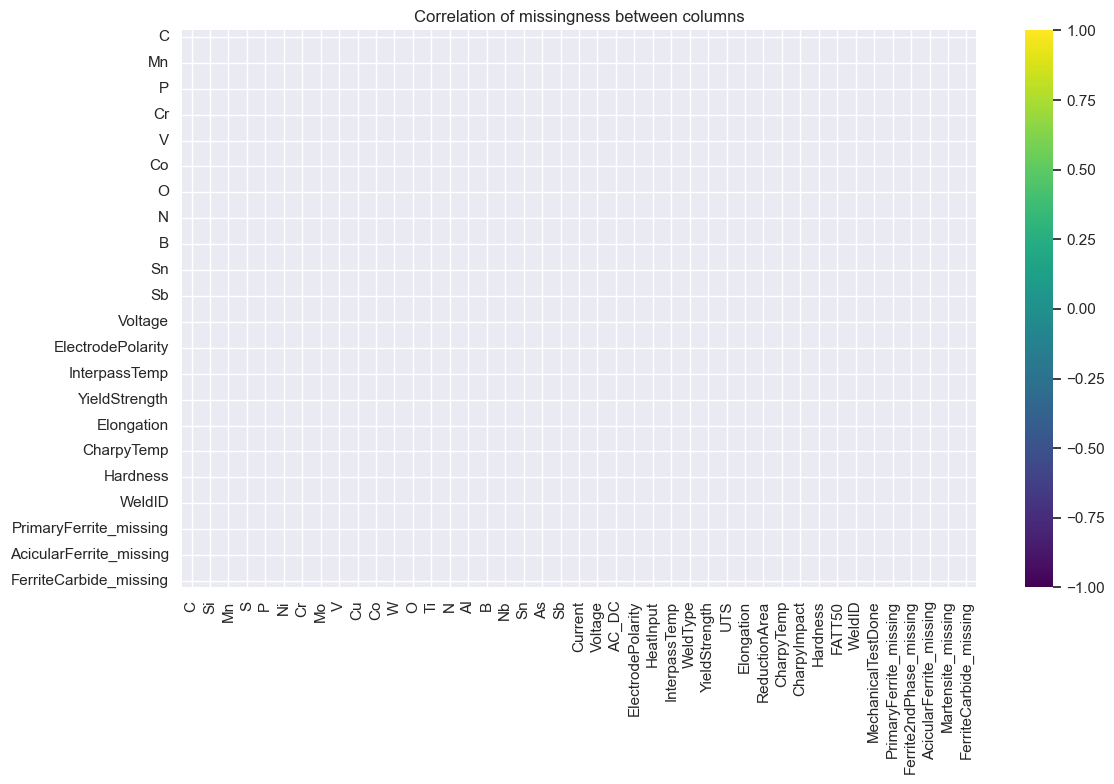

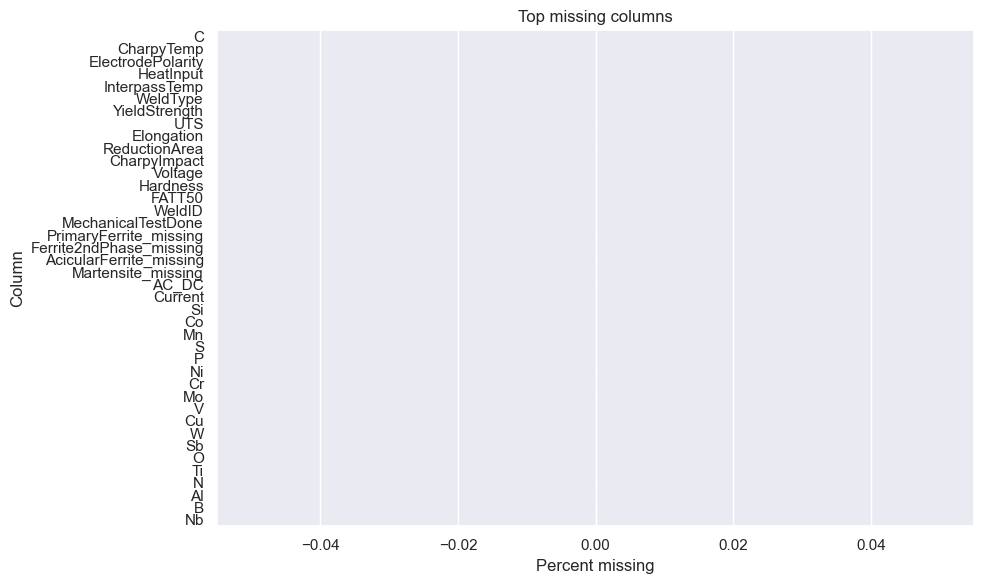

In [63]:
# Heatmap of missing values
mvh.plot_missingness(method='heatmap')

# Barplot of missing values
mvh.plot_missingness(method='bar')

In [66]:
# 2. Handle process parameters (mostly MCAR/quasi-MCAR)
process_param_columns = [
    'Current', 'Voltage','AC_DC', 'ElectrodePolarity',
    'HeatInput', 'InterpassTemp', 'WeldType', 'PWHT_Temp', 'PWHT_Time'
]
mvh.simple_impute_for_process_params(process_param_columns=process_param_columns)

# 3. Clean chemical columns (likely MAR)
chem_cols = [
    'C', 'Si', 'Mn', 'S', 'P', 'Ni', 'Cr', 'Mo', 'V',
    'Cu', 'Co', 'W', 'O','Ti', 'N', 'Al', 'B', 'Nb', 'Sn', 'As', 'Sb'
]
mvh.clean_chemical_columns(chem_cols=chem_cols)
mvh.iterative_impute_columns(columns=chem_cols, max_iter=10)

# # 4. Handle mechanical properties (likely MAR)
# mech_cols = [
#     'YieldStrength', 'UTS', 'Elongation', 'ReductionArea',
#     'CharpyTemp', 'CharpyImpact', 'Hardness', 'FATT50'
# ]
# mvh.clean_and_impute_mechanical(mech_cols=mech_cols, create_flag=True, max_iter=10)

# # 5. Handle microstructure (likely MNAR)
# micro_cols = [
#     'PrimaryFerrite', 'Ferrite2ndPhase', 'AcicularFerrite',
#     'Martensite', 'FerriteCarbide'
# ]
# # Create MNAR indicators
# mvh.mark_mnar(columns=micro_cols)

# # 6. Optional: drop rows/columns exceeding missingness thresholds
# mvh.drop_by_threshold(col_thresh=0.5, row_thresh=0.5)


clean_chemical_columns: C coerced, added 0 NaNs
clean_chemical_columns: Si coerced, added 0 NaNs
clean_chemical_columns: Mn coerced, added 0 NaNs
clean_chemical_columns: S coerced, added 0 NaNs
clean_chemical_columns: P coerced, added 0 NaNs
clean_chemical_columns: Ni coerced, added 0 NaNs
clean_chemical_columns: Cr coerced, added 0 NaNs
clean_chemical_columns: Mo coerced, added 0 NaNs
clean_chemical_columns: V coerced, added 0 NaNs
clean_chemical_columns: Cu coerced, added 0 NaNs
clean_chemical_columns: Co coerced, added 0 NaNs
clean_chemical_columns: W coerced, added 0 NaNs
clean_chemical_columns: O coerced, added 0 NaNs
clean_chemical_columns: Ti coerced, added 0 NaNs
clean_chemical_columns: N coerced, added 0 NaNs
clean_chemical_columns: Al coerced, added 0 NaNs
clean_chemical_columns: B coerced, added 0 NaNs
clean_chemical_columns: Nb coerced, added 0 NaNs
clean_chemical_columns: Sn coerced, added 0 NaNs
clean_chemical_columns: As coerced, added 0 NaNs
clean_chemical_columns: Sb c

In [67]:
# Quick evaluation of imputation strategies
# We'll mask a fraction of observed values and measure imputation quality

# Choose a subset of columns to evaluate
eval_cols = chem_cols[:5] + mech_cols[:3] + process_param_columns[:3]

# Use 10% masking for testing
mask_fraction = 0.1

# Evaluate median imputation for numeric and mode for categorical
eval_results = mvh.evaluate_imputation(
    holdout_cols=eval_cols,
    mask_frac=mask_fraction,
    strategy='median'  # 'median' for numeric, mode internally for categorical
)

# Show results
print("Imputation evaluation results:")
print(eval_results)


Imputation evaluation results:
              col    metric         score
0               C       mse      0.000627
1              Si       mse      0.012620
2              Mn       mse      0.164605
3               S       mse      0.000027
4               P       mse      0.000066
5   YieldStrength       mse  19126.656188
6             UTS       mse   4696.711059
7      Elongation       mse     46.834260
8         Current       mse  59776.183594
9         Voltage       mse    198.737411
10          AC_DC  accuracy      0.975758


c:\Users\clemm\Documents\CentraleSupelec\IA\ML\Weld-quality-prediction\notebooks\../src\preprocessing\data_cleaning.py:566: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp_df[col].fillna(temp_df[col].median(), inplace=True)
c:\Users\clemm\Documents\CentraleSupelec\IA\ML\Weld-quality-prediction\notebooks\../src\preprocessing\data_cleaning.py:566: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplac

**Quick snapshot of imputation performance**:

Chemical elements (C, Si, Mn, S, P): Very low MSE, so median imputation works well for these. Only Mn is a bit higher (~0.16), suggesting more variability or outliers.

Process parameters (Current, Voltage, AC_DC): Current has huge MSE (~59k) — maybe strong variability or missing patterns. Voltage is fine (~198), AC_DC (categorical) has high accuracy (0.976), so mode imputation works well.

**Takeaways**:

For chemicals, simple median works fine.

For process parameters, check if Current has extreme outliers — maybe use KNN or domain-specific imputation.